In [2]:
#hide
#! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

In [3]:
types = 'papaya plant','chaya plant', 'papaya fruit'
path = Path('training_images')

In [8]:
runEvenWhenAlreadyExist = False

def searchImages():
    results = search_images_ddg(f'{o}',150)
    download_images(dest, urls=results)
    
if not path.exists():
    path.mkdir()
for o in types:
    dest = (path/o)
    if dest.exists() and runEvenWhenAlreadyExist:
        searchImages()
    elif not dest.exists():
        dest.mkdir(exist_ok=True)
        searchImages()

In [5]:
fns = get_image_files(path)
fns

(#421) [Path('training_images/chaya plant/01418893-00ee-4807-85b5-f367e16e4e73.jpg'),Path('training_images/chaya plant/036419ab-43ca-41ab-85dd-ed23a4ed727d.jpg'),Path('training_images/chaya plant/09cc050a-96ff-4699-a2ca-0ade7b95e5ff.jpg'),Path('training_images/chaya plant/0b2a28ab-b0c3-436a-aa23-1ad030d4fc7f.jpg'),Path('training_images/chaya plant/0c852e62-e47e-46b4-be5f-e88743ced2ab.jpg'),Path('training_images/chaya plant/0d5e3263-f0fa-461a-8bc0-06d1e9ce82bc.jpeg'),Path('training_images/chaya plant/115df05b-999b-4c92-a2a9-8b987f1a8ff3.jpg'),Path('training_images/chaya plant/13c7ff60-a9e4-488f-90ca-6e74822a9dd9.jpg'),Path('training_images/chaya plant/169f92bd-bd00-4394-bff7-9191638bc006.jpg'),Path('training_images/chaya plant/175276f1-699e-48d4-a39c-3ed66f3e15d0.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#7) [Path('training_images/chaya plant/403e8d4d-32a9-4a34-ae98-36b88b67c1f7.jpg'),Path('training_images/chaya plant/5bd99c62-332c-4d1c-9b09-bb6ce70334b1.jpg'),Path('training_images/chaya plant/bfec0cea-cd2e-4b5f-966f-e02a5624c0a8.jpg'),Path('training_images/chaya plant/e7272dfb-907f-410f-87ec-5cf906644c02.jpg'),Path('training_images/chaya plant/ee4ae240-0a80-4462-8de6-b5cf4909642b.jpg'),Path('training_images/papaya fruit -plant/507f1b1f-cadc-49b5-8135-ec0f5cd1c0bd.jpg'),Path('training_images/papaya fruit -plant/e1d6d0d4-6cf2-42c3-b4c1-2378d79e7c5f.jpg')]

In [7]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [18]:
training_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dlss = training_data.dataloaders(path)

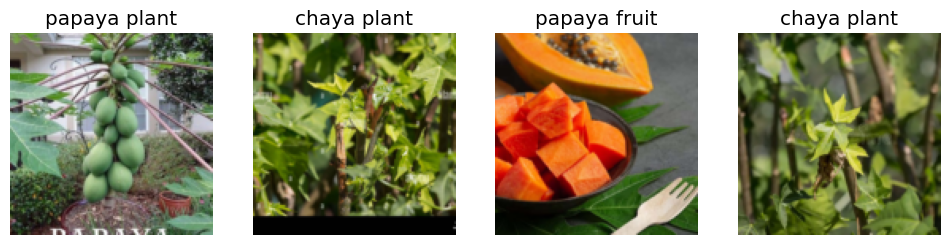

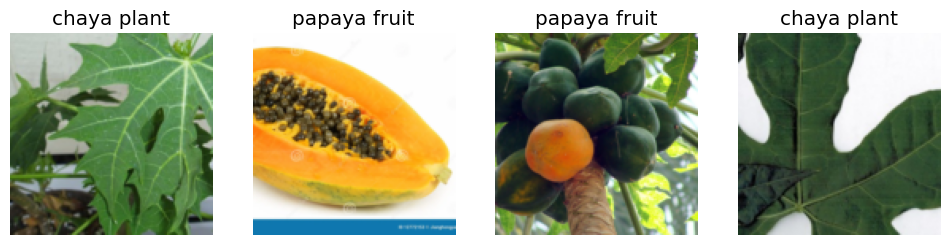

In [20]:
dlss.valid.show_batch(max_n=4, nrows=1)
dlss.train.show_batch(max_n=4, nrows=1)

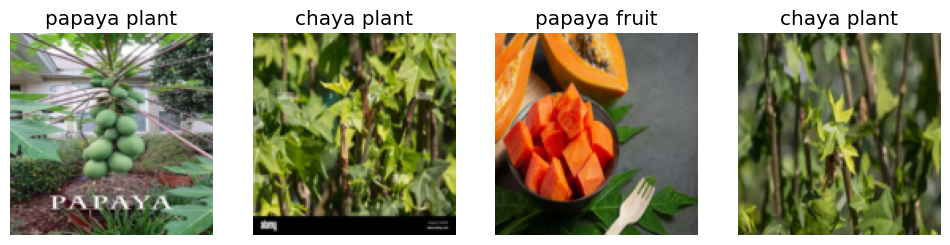

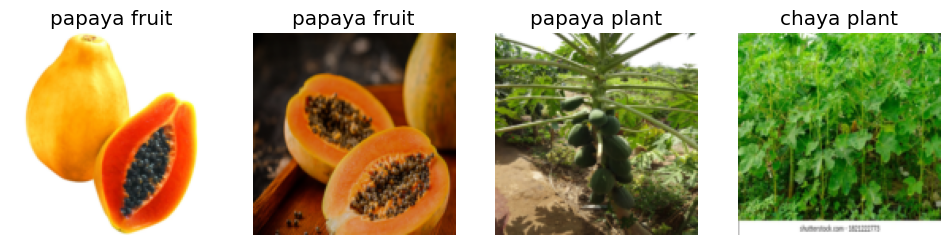

In [21]:
training_data = training_data.new(item_tfms=Resize(128, ResizeMethod.Squish))
dlss = training_data.dataloaders(path)
dlss.valid.show_batch(max_n=4, nrows=1)
dlss.train.show_batch(max_n=4, nrows=1)

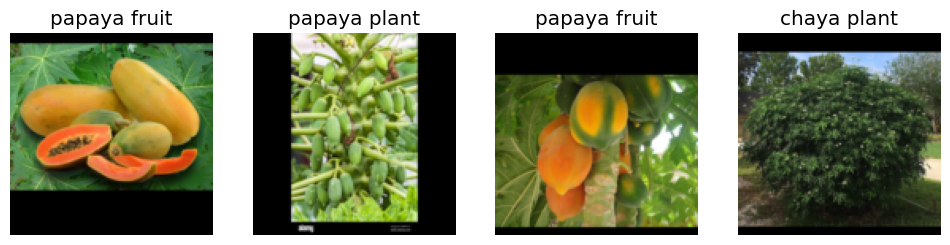

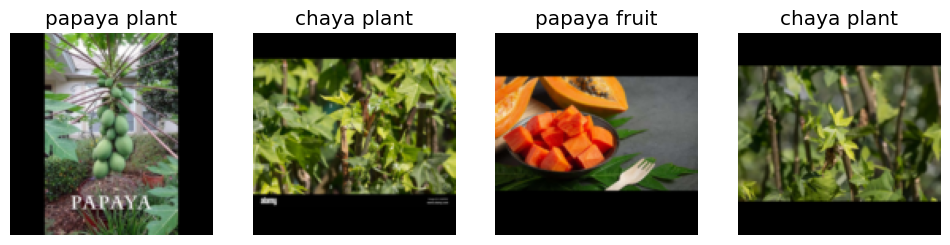

In [22]:
training_data = training_data.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dlss = training_data.dataloaders(path)
dlss.train.show_batch(max_n=4, nrows=1)
dlss.valid.show_batch(max_n=4, nrows=1)

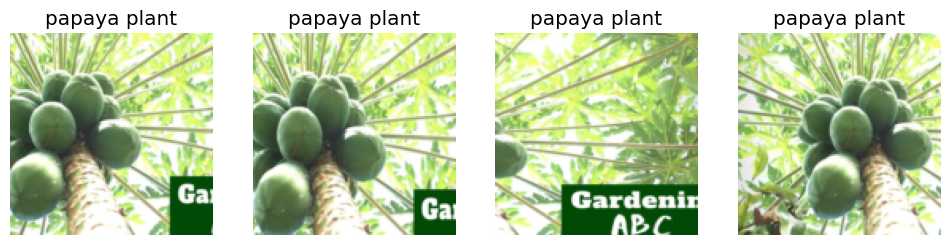

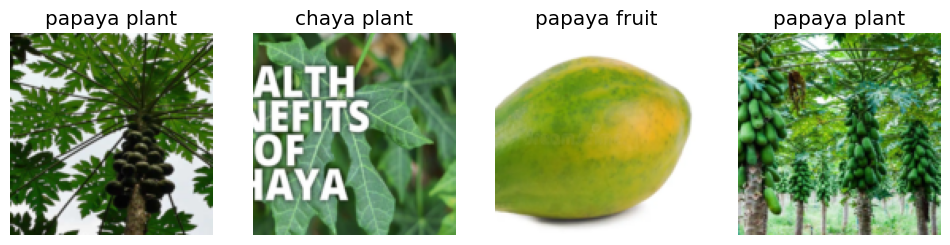

In [23]:
training_data = training_data.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dlss = training_data.dataloaders(path)
dlss.train.show_batch(max_n=4, nrows=1, unique=True)
dlss.train.show_batch(max_n=4, nrows=1)

### Data Augmentation

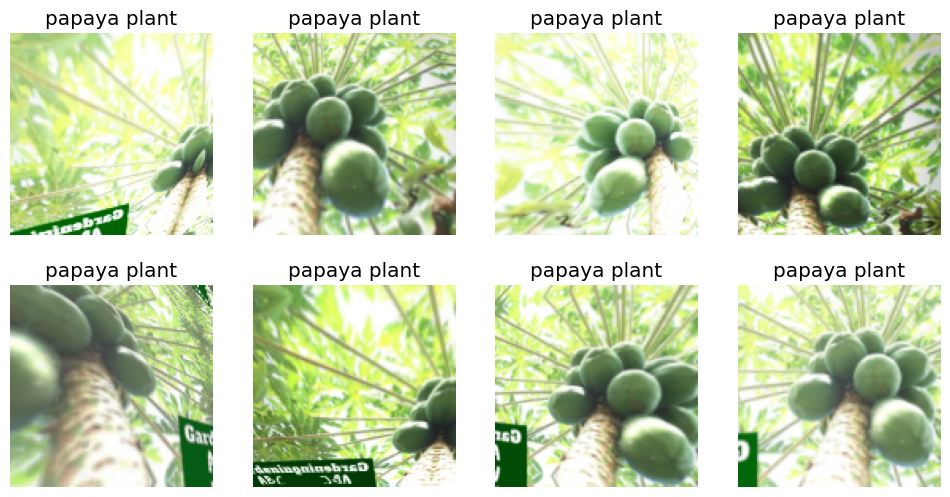

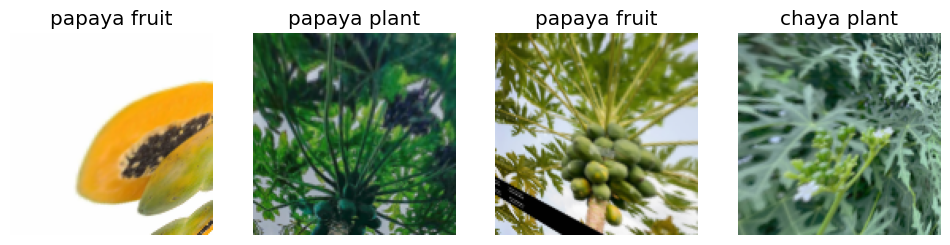

In [24]:
training_data = training_data.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dlss = training_data.dataloaders(path)
dlss.train.show_batch(max_n=8, nrows=2, unique=True)
dlss.train.show_batch(max_n=4, nrows=1)

## Training Your Model, and Using It to Clean Your Data

In [25]:
training_data = training_data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dlss = training_data.dataloaders(path)

In [26]:
learn = vision_learner(dlss, resnet18, metrics=error_rate)
learn.fine_tune(4)

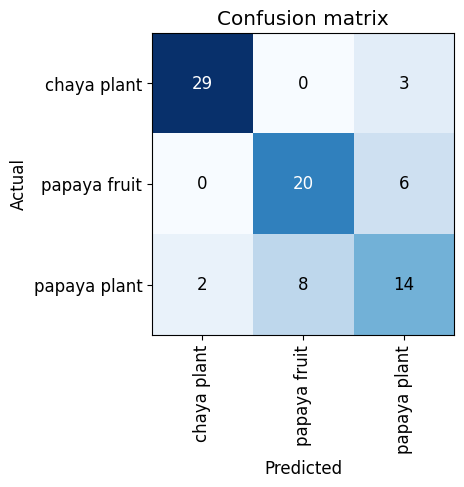

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

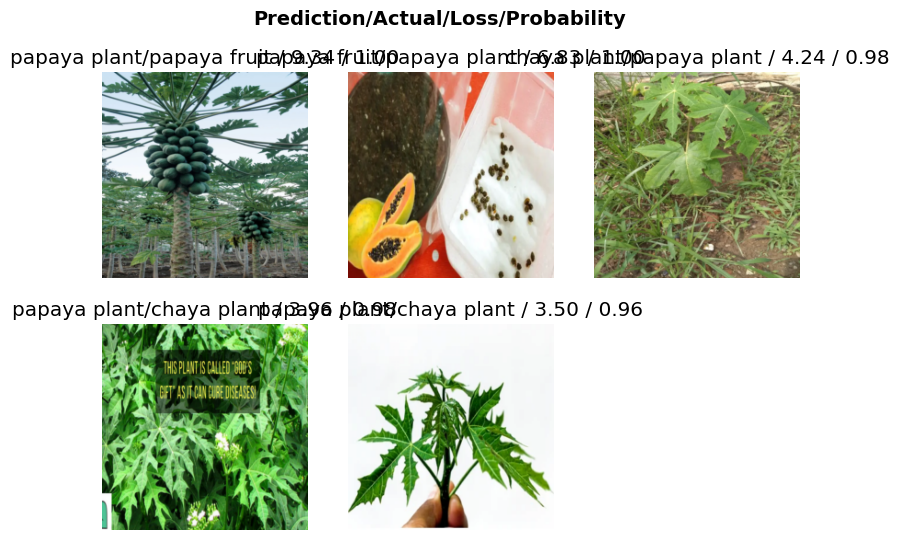

In [28]:
amount_top_losses = 5
interp.plot_top_losses(amount_top_losses, nrows=amount_top_losses)

In [30]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

C:\Users\ASUS\miniforge3\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [29]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

NameError: name 'cleaner' is not defined

## Using the Model for Inference

In [30]:
path = Path('training_export')
if not path.exists():
    path.mkdir()
filename = "export.pkl"
learn.export(path/filename)

In [31]:
path.ls(file_exts='.pkl')

(#1) [Path('training_export/export.pkl')]

In [33]:
learn.dls.vocab

['chaya plant', 'papaya fruit', 'papaya plant']

## Testing Data

In [4]:
path = Path('training_export')
filename = "export.pkl"

In [5]:
learn_inf = load_learner(path/filename)

In [6]:
import os
import filetype
import pathlib

def predictImageInNestedDirs(directory):
    for filepath in (pathlib.Path.cwd() / directory).iterdir():
        print("file: ",repr(filepath))
        isDir = os.path.isdir(filepath)
        if(isDir):
            predictImageInNestedDirs(filepath)
        elif(filetype.is_image(filepath)):
            print(learn_inf.predict(filepath))

directory = "./images"  
predictImageInNestedDirs(directory)

file:  Path('C:/Users/ASUS/Documents/others/course.fast.ai/chapter 2/papaya_vs_chaya/images/chaya')
file:  Path('C:/Users/ASUS/Documents/others/course.fast.ai/chapter 2/papaya_vs_chaya/images/chaya/chaya leaf.jpg')


('chaya plant', tensor(0), tensor([9.9979e-01, 1.8846e-04, 2.4080e-05]))
file:  Path('C:/Users/ASUS/Documents/others/course.fast.ai/chapter 2/papaya_vs_chaya/images/chaya/chaya plants.jpg')


('chaya plant', tensor(0), tensor([0.8155, 0.0036, 0.1809]))
file:  Path('C:/Users/ASUS/Documents/others/course.fast.ai/chapter 2/papaya_vs_chaya/images/papaya')
file:  Path('C:/Users/ASUS/Documents/others/course.fast.ai/chapter 2/papaya_vs_chaya/images/papaya/papaya fruit.jpg')


('papaya fruit', tensor(1), tensor([5.2012e-08, 1.0000e+00, 8.5132e-07]))
file:  Path('C:/Users/ASUS/Documents/others/course.fast.ai/chapter 2/papaya_vs_chaya/images/papaya/papaya leaf.jpg')


('chaya plant', tensor(0), tensor([0.9970, 0.0018, 0.0012]))
file:  Path('C:/Users/ASUS/Documents/others/course.fast.ai/chapter 2/papaya_vs_chaya/images/papaya/papaya plant and fruit.jpg')


('papaya fruit', tensor(1), tensor([0.0014, 0.9776, 0.0210]))


## [OPTIONAL] Creating Classify Button from the Model

In [34]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [35]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()

In [36]:
#hide_output
lbl_pred = widgets.Label()

In [37]:
#hide_output
btn_run = widgets.Button(description='Classify')

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
#hide_output
VBox([widgets.Label('Upload papaya or chaya plant images!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## [NOT WORKING] Deploying your app

To show off initial prototype of the application (or any hobby projects), you can use [Binder](https://mybinder.org/). Follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `voila/render/app.ipynb`.
5. Click the clickboard button at the bottom right to copy the URL and paste it somewhere safe. 
6. Click Launch.